<a href="https://colab.research.google.com/github/parkhae/project/blob/main/section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

In [4]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [79]:
import pandas as pd

train = pd.read_csv('train.csv', encoding='cp949')
test = pd.read_csv('test.csv', encoding='cp949')
submission = pd.read_csv('sample_submission.csv', encoding='cp949')
train
#num : 건물번호

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [80]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
equipment = train[['num', '비전기냉방설비운영', '태양광보유']].drop_duplicates()
equipment.head()

,num,비전기냉방설비운영,태양광보유
0,1,0.0,0.0
2040,2,1.0,0.0
4080,3,1.0,1.0
6120,4,1.0,1.0
8160,5,1.0,0.0


In [44]:
test = test.drop(columns=['비전기냉방설비운영','태양광보유'])
test = pd.merge(test, equipment, on='num')
test = test.interpolate(method='values')
test = test.rename(columns = {'강수량(mm, 6시간)':'강수량(mm)','일조(hr, 3시간)':'일조(hr)'})
test

,num,date_time,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0


In [45]:
train['time'] = train['date_time'].apply(lambda x: int(x[-2:]))
test['time'] = test['date_time'].apply(lambda x: int(x[-2:]))
train['weekday'] = train['date_time'].apply(lambda x: pd.to_datetime(x[:10]).weekday())
test['weekday'] = test['date_time'].apply(lambda x: pd.to_datetime(x[:10]).weekday())
train = train.drop(columns='date_time')
test = test.drop(columns='date_time')
test

,num,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,time,weekday
0,1,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0,0,1
1,1,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0,1,1
2,1,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0,2,1
3,1,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0,3,1
4,1,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0,4,1
...,...,...,...,...,...,...,...,...,...,...
10075,60,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0,19,0
10076,60,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0,20,0
10077,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,21,0
10078,60,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0,22,0


In [50]:
X_train = train.drop(columns='전력사용량(kWh)')
y_train = train['전력사용량(kWh)']

In [51]:
from sklearn.model_selection import train_test_split
target = '전력사용량(kWh)'

train, val = train_test_split(train, train_size = 0.8, random_state = 2)
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

In [52]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#타겟인 전력사용량의 평균을 기준모델으로 사용, MAE 계산
pred = y_train.mean()
pred = [pred] * len(train)

MAE = mean_absolute_error(pred, y_train)
RMSE = mean_squared_error(pred, y_train, squared=False)
print('MAE, RMSE : ', MAE,',', RMSE)

MAE, RMSE :  1375.8928434129868 , 2048.8285293678564


In [53]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_val_pred = lr.predict(X_val)

MAE = mean_absolute_error(y_val_pred, y_val)
RMSE = mean_squared_error(y_val_pred, y_val, squared=False)
print('MAE, RMSE : ', MAE,',', RMSE)

MAE, RMSE :  1293.9452454841867 , 2014.5643379966068


In [78]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=2000,
    max_depth=5,
    n_jobs=-1,
    random_state=2,
    learning_rate=0.01
)

eval_set = [(X_train, y_train), (X_val, y_val)]

xgb.fit(X_train, y_train, eval_set = eval_set,
        early_stopping_rounds=10,
        verbose = 0)

[04:11:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [56]:
y_val_pred = xgb.predict(X_val)
MAE = mean_absolute_error(y_val_pred, y_val)
RMSE = mean_squared_error(y_val_pred, y_val,squared=False)
print('MAE, RMSE : ', MAE,',', RMSE)

MAE, RMSE :  257.3067541405531 , 393.13512900550734


In [57]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np


dists = {
    'min_child_weight' : np.arange(1,8,1),
    'max_depth' : np.arange(3,9,1)
}

xgb = XGBRegressor(
    n_estimators=2000,
    random_state=2,
    learning_rate=0.01
)

clf = RandomizedSearchCV(
    xgb,
    param_distributions=dists,
    n_iter=5,
    cv=2,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.2min finished


[01:51:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=2000,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=2, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                

In [58]:
clf.best_params_

{'max_depth': 8, 'min_child_weight': 4}

In [59]:
best = clf.best_estimator_
y_pred = best.predict(X_val)

MAE = mean_absolute_error(y_pred, y_val)
RMSE = mean_squared_error(y_pred, y_val,squared=False)
print('MAE, RMSE : ', MAE,',', RMSE)

MAE, RMSE :  146.5243717634921 , 249.5732540234642


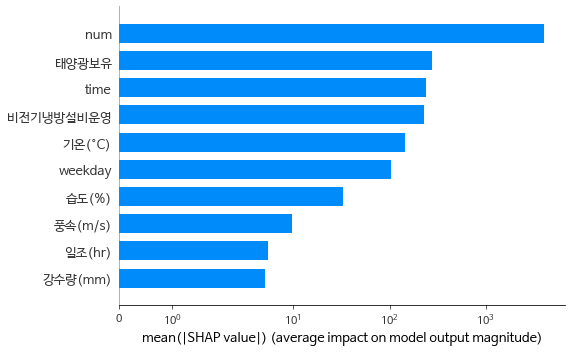

In [70]:
import shap

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(test.iloc[:300])
shap.initjs()
shap.summary_plot(shap_values, test.iloc[:300], plot_type='bar',use_log_scale=True)

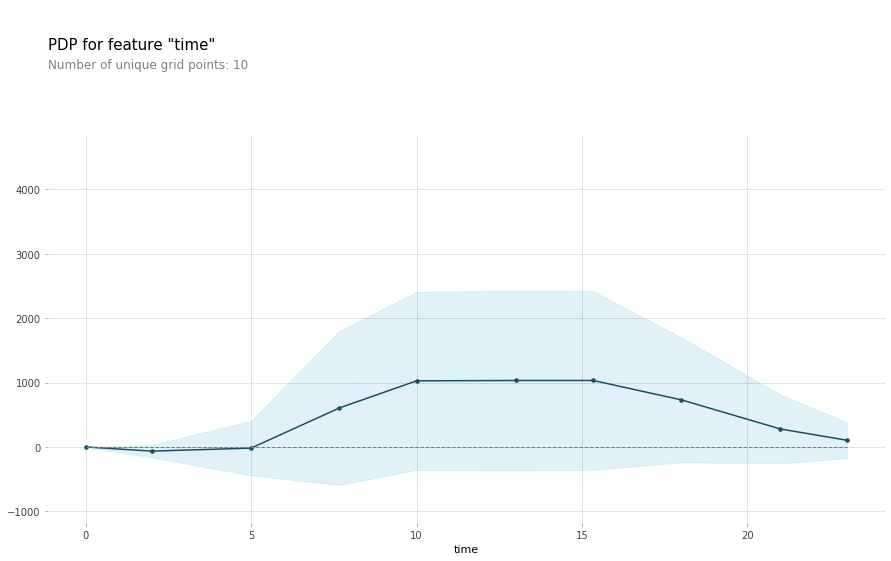

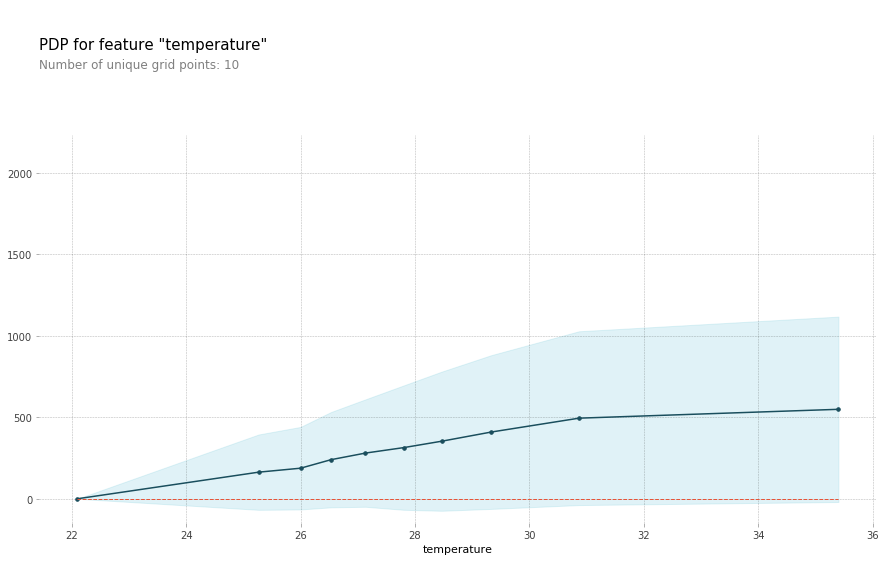

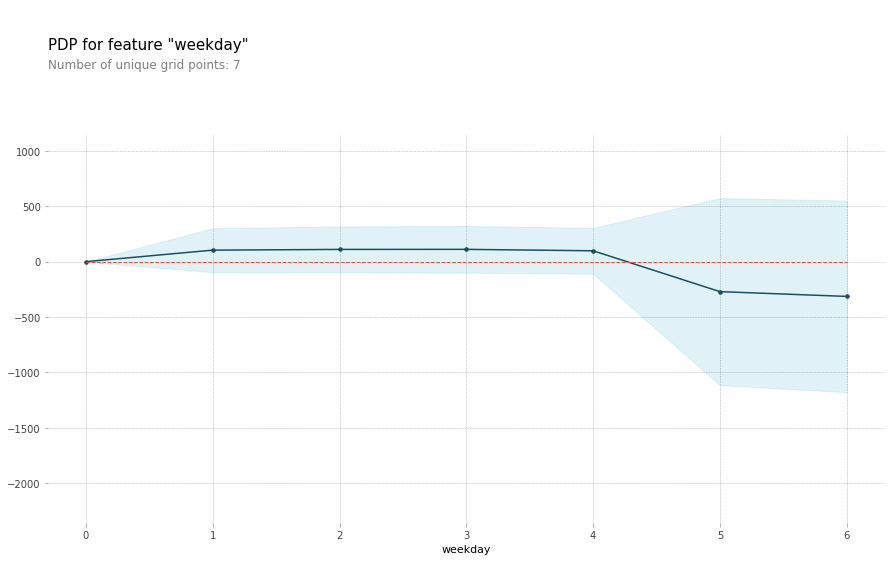

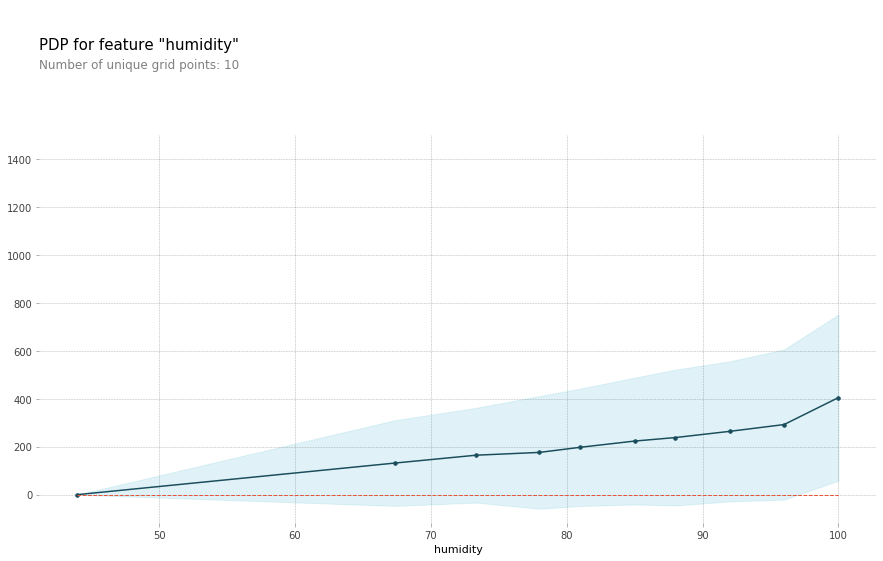

In [77]:
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = ['time','기온(°C)','weekday','습도(%)']
feature_name = ['time','temperature','weekday','humidity']

for i,j in zip(feature, feature_name):
  isolated = pdp_isolate(
      model=best,
      dataset=test,
      model_features=test.columns,
      feature=i,
  )
  pdp_plot(isolated, feature_name=j)